In [1]:
!pip install kaggle


#Importing Data

In [29]:
#Code from kaggle
import kagglehub

path = kagglehub.dataset_download("mostafaabla/garbage-classification")

print("Path to dataset files:", path)

KeyboardInterrupt: 

In [5]:
import shutil
import os

# source and destination paths
source_path = '/kaggle/input/garbage-classification/garbage_classification'
destination_path = '/content/garbage_classification_writable'


if not os.path.exists(destination_path):
    os.makedirs(destination_path)

# the dataset
print(f"Copying data from {source_path} to {destination_path}...")
shutil.copytree(source_path, destination_path, dirs_exist_ok=True)
print("Copy complete.")

Copying data from /kaggle/input/garbage-classification/garbage_classification to /content/garbage_classification_writable...
Copy complete.


# Cleaning data

In [6]:
!pip install imagehash opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 5.9 MB/s eta 0:00:00


In [7]:
from pathlib import Path
import os, shutil, hashlib, json, csv, random
from PIL import Image, UnidentifiedImageError
import numpy as np
import pandas as pd
from tqdm import tqdm
import imagehash
import cv2

In [8]:

from google.colab import drive
drive.mount('/content/drive')


!pip install tensorflow pillow opencv-python imagehash pandas tqdm matplotlib seaborn scikit-learn

# Import libraries
import os
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

Mounted at /content/drive


In [9]:
data_path = Path('/content/garbage_classification_writable')
print("Class folders:", os.listdir(data_path))

Class folders: ['paper', 'trash', 'cardboard', 'plastic', 'clothes', 'metal', 'shoes', 'battery', 'green-glass', 'brown-glass', 'biological', 'white-glass']


In [10]:
#corrupt image removal
def is_valid_image(img_path):
    try:
        with Image.open(img_path) as img:
            img.verify()
        return True
    except:
        return False

valid_images = []
for folder in data_path.iterdir():
    if folder.is_dir():
        for img in folder.iterdir():
            if is_valid_image(img):
                valid_images.append(img)

In [11]:
from PIL import Image

def preprocess_and_save(img_path, target_size=(224,224)):
    with Image.open(img_path) as img:
        img = img.convert('RGB')
        img = img.resize(target_size)
        img.save(img_path)

for folder in data_path.iterdir():
    if folder.is_dir():
        for img in tqdm(folder.iterdir(), desc=f"Resizing {folder.name}"):
            preprocess_and_save(img)

Resizing paper: 1050it [00:04, 261.82it/s]
Resizing trash: 697it [00:01, 535.65it/s]
Resizing cardboard: 891it [00:03, 251.00it/s]
Resizing plastic: 865it [00:02, 313.89it/s]
Resizing clothes: 5325it [00:28, 189.26it/s]
Resizing metal: 769it [00:02, 340.42it/s]
Resizing shoes: 1977it [00:05, 362.92it/s]
Resizing battery: 945it [00:02, 376.49it/s]
Resizing green-glass: 629it [00:01, 454.50it/s]
Resizing brown-glass: 607it [00:01, 444.75it/s]
Resizing biological: 985it [00:01, 512.04it/s]
Resizing white-glass: 775it [00:02, 379.45it/s]


In [12]:
import shutil, random

train_dir = Path('/content/data/train')
val_dir = Path('/content/data/val')
test_dir = Path('/content/data/test')

for split_dir in [train_dir, val_dir, test_dir]:
    split_dir.mkdir(parents=True, exist_ok=True)

split_ratio = {'train': 0.7, 'val': 0.15, 'test': 0.15}
random.seed(42)

for folder in data_path.iterdir():
    if folder.is_dir():
        images = list(folder.iterdir())
        random.shuffle(images)
        n_train = int(split_ratio['train'] * len(images))
        n_val = int(split_ratio['val'] * len(images))

        for img in images[:n_train]:
            dest = train_dir / folder.name
            dest.mkdir(exist_ok=True)
            shutil.copy(img, dest)
        for img in images[n_train:n_train+n_val]:
            dest = val_dir / folder.name
            dest.mkdir(exist_ok=True)
            shutil.copy(img, dest)
        for img in images[n_train+n_val:]:
            dest = test_dir / folder.name
            dest.mkdir(exist_ok=True)
            shutil.copy(img, dest)

# EDA

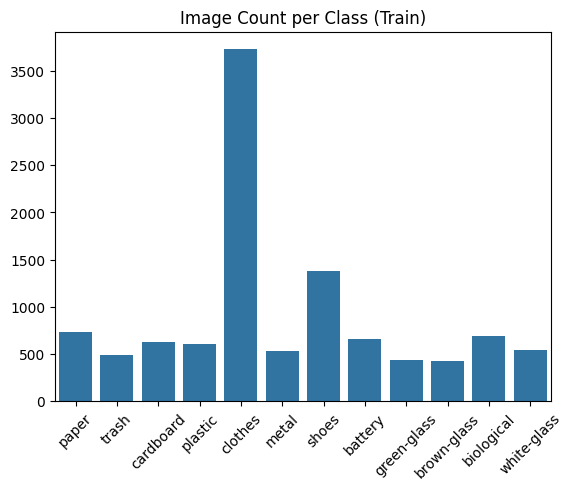

In [13]:
import glob
from collections import Counter

train_counts = {}
for folder in train_dir.iterdir():
    train_counts[folder.name] = len(list(folder.iterdir()))

sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.xticks(rotation=45)
plt.title("Image Count per Class (Train)")
plt.show()

In [14]:
import os

dataset_path = '/content/data/train'
categories = os.listdir(dataset_path)
print("Classes found:", categories)

Classes found: ['paper', 'trash', 'cardboard', 'plastic', 'clothes', 'metal', 'shoes', 'battery', 'green-glass', 'brown-glass', 'biological', 'white-glass']


In [15]:
class_counts = {cls: len(os.listdir(os.path.join(dataset_path, cls))) for cls in categories}
print("Image counts per class:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

Image counts per class:
paper: 735
trash: 487
cardboard: 623
plastic: 605
clothes: 3727
metal: 538
shoes: 1383
battery: 661
green-glass: 440
brown-glass: 424
biological: 689
white-glass: 542


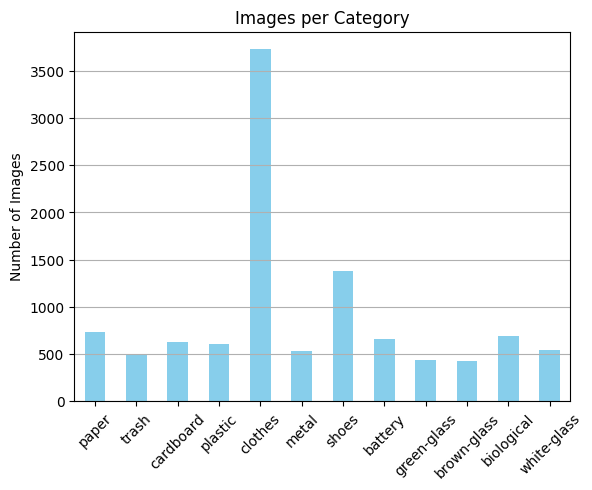

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count'])
df.plot(kind='bar', legend=False, title='Images per Category', rot=45, color='skyblue')
plt.ylabel('Number of Images')
plt.grid(axis='y')
plt.show()


# MODEL TRAINING


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

datagen_train = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=15)
datagen_val = ImageDataGenerator(rescale=1./255)

dtrain = datagen_train.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
dval = datagen_val.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

Found 10854 images belonging to 12 classes.
Found 2321 images belonging to 12 classes.


In [18]:
from tensorflow.keras import layers, models

model_cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(12, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_cnn = model_cnn.fit(dtrain, validation_data=dval, epochs=10)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 138s 384ms/step - accuracy: 0.4024 - loss: 2.9229 - val_accuracy: 0.5773 - val_loss: 1.2934
Epoch 2/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 134s 377ms/step - accuracy: 0.6227 - loss: 1.1541 - val_accuracy: 0.6665 - val_loss: 1.0508
Epoch 3/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 130s 381ms/step - accuracy: 0.6799 - loss: 0.9656 - val_accuracy: 0.6678 - val_loss: 1.0320
Epoch 4/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 128s 376ms/step - accuracy: 0.7272 - loss: 0.8285 - val_accuracy: 0.6855 - val_loss: 0.9805
Epoch 5/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 128s 375ms/step - accuracy: 0.7540 - loss: 0.7567 - val_accuracy: 0.7169 - val_loss: 0.9383
Epoch 6/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 143s 378ms/step - accuracy: 0.7740 - loss: 0.6707 - val_accuracy: 0.7152 - val_loss: 0.9371
Epoch 7/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 132s 389ms/step - accuracy: 0.7847 - loss: 0.6584 - val_accuracy: 0.7505 - val_loss: 0.8590
Epoch 8/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 127s 374ms/step - accuracy: 0.8136 -

In [19]:
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

model_mobilenet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(12, activation='softmax')
])

model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_mobilenet = model_mobilenet.fit(dtrain, validation_data=dval, epochs=10)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 147s 403ms/step - accuracy: 0.7414 - loss: 0.8281 - val_accuracy: 0.9156 - val_loss: 0.2664
Epoch 2/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 128s 375ms/step - accuracy: 0.9140 - loss: 0.2782 - val_accuracy: 0.9255 - val_loss: 0.2289
Epoch 3/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 126s 371ms/step - accuracy: 0.9288 - loss: 0.2163 - val_accuracy: 0.9328 - val_loss: 0.2195
Epoch 4/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 126s 371ms/step - accuracy: 0.9445 - loss: 0.1653 - val_accuracy: 0.9302 - val_loss: 0.2349
Epoch 5/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 127s 373ms/step - accuracy: 0.9508 - loss: 0.1448 - val_accuracy: 0.9319 - val_loss: 0.2048
Epoch 6/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 129s 378ms/step - accuracy: 0.9533 - loss: 0.1461 - val_accuracy: 0.9427 - val_loss: 0.2047
Epoch 7/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 128s 378ms/step - accuracy: 0.9611 - loss: 0.1125 - val_accuracy: 0.9349 - val_loss: 0.2024
Epoch 8/10
340/340 ━━━━━━━━

# Evaluation

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

dtest = datagen_val.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

preds = model_mobilenet.predict(dtest)
y_pred = np.argmax(preds, axis=1)
print(classification_report(dtest.classes, y_pred, target_names=dtest.class_indices.keys()))

Found 2340 images belonging to 12 classes.
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step
              precision    recall  f1-score   support

     battery       0.98      0.92      0.95       143
  biological       0.97      0.96      0.96       149
 brown-glass       0.86      0.87      0.86        92
   cardboard       0.88      0.93      0.91       135
     clothes       0.98      0.98      0.98       800
 green-glass       0.89      0.89      0.89        95
       metal       0.74      0.86      0.80       116
       paper       0.92      0.85      0.88       158
     plastic       0.82      0.82      0.82       131
       shoes       0.95      0.96      0.96       298
       trash       0.93      0.91      0.92       106
 white-glass       0.83      0.74      0.78       117

    accuracy                           0.92      2340
   macro avg       0.90      0.89      0.89      2340
weighted avg       0.92      0.92      0.92      2340



# Inference and saving model

In [22]:
model_mobilenet.save('/content/models/best_model.keras')

In [28]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image

model = load_model('/content/models/best_model.keras')

img_path = '/content/data/test/battery/battery101.jpg'
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
class_idx = np.argmax(pred, axis=1)[0]
print("Predicted class:", list(dtrain.class_indices.keys())[class_idx])

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted class: battery
